In [17]:
using Plots, LinearAlgebra, Statistics, BenchmarkTools
using HermiteGF
using SparseArrays

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$

- [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)

In [18]:
nx = 64
matrix = spdiagm(-1 => ones(Float64,nx-2),
                   0 => -2*ones(Float64,nx),
                   1 => ones(Float64,nx-2))

typeof(matrix)

SparseMatrixCSC{Float64,Int64}

In [19]:
struct UniformMesh
    nx :: Int64
    dx :: Float64
    x  :: Vector{Float64}
    function UniformMesh( xmin, xmax, nx)
        dx = (xmax - xmin)/ nx
        x = range(xmin, stop=xmax, length=nx+1)[1:end-1]
        new( nx, dx, x)
    end
end

In [21]:
struct ChebyshevMesh
    nx :: Int64
    x  :: Vector{Float64}
    dx :: Vector{Float64}
    function ChebyshevMesh( nodes::HermiteGF.NodesType)
        dx =[ x1 - x0 for (x1,x0) in zip(nodes.xk[2:end],nodes[1:end-1]) ]
        x = nodes.xk
        new( nx, dx, x)
    end
end

$$
f_i'' \approx \frac{2 \Big[ f_{i+1}
- \big(1+\frac{h_i}{h_{i-1}}\big) f_i
+\frac{h_i}{h_{i-1}}f_{i-1} 
 \Big]}
{ h_i h_{i-1} (1+\frac{h_i}{h_{i-1}})}
$$

In [ ]:
## Julia implementation of solving Poisson on a square grid using Chebyshev collocation
# julia> load("logg.jl")
# julia> loggProfile(10000)
# error: 3.310154100518143e-7
# Average time (us): 132.39421844482422

function logg(m)
    (D,xb) = cheb(m+1) # Chebyshev differentiation matrix and nodes
    D = 2*D; xb = 0.5 .+ 0.5*xb   # Remap to interval [0,1]
    D2 = -(D*D)[2:end-1,2:end-1] # Negative 1D Laplacian, with Dirichlet BCs
    xd = xb[2:end-1]             # Remove Dirichlet BCs
    sinx = sin.(pi*xd'')
    xexact = kron(sinx', sinx)   # sin(pi*x)*sin(pi*y)
    b = 2*pi^2*xexact
    # Compute action of inverse of L using sum factorization
    # See Lynch, Rice, and Thomas (1964)
    (Lambda, R) = eig(D2)
    e = ones(m)
    Diag = kron(Lambda,e) + kron(e,Lambda)
    iDiag = 1/Diag
    Rinv = inv(R)
    # L = kron(D2,eye(m)) + kron(eye(m),D2)
    # Linv = kron(R,R) * diagm(reshape(iDiag,m^2,1)) * kron(Rinv,Rinv)
    x = R * (iDiag .* (Rinv*b*Rinv')) * R' # x = Linv * b  (with reshaping)
    norm(reshape(x - xexact,m^2,1))        # L2 norm of the vector
end

function cheb(N)
    x = cos.(pi*(0:N)/N)
    c = ones(N+1)
    c[1] = 2
    c[end] = 2
    for i in 2:2:N+1
        c[i] = - c[i]
    end
    X = repeat(x,1,N+1)
    dX = X .- X'
    D = (c*(1/c')) ./ (dX+eye(N+1))  # off-diagonal entries
    D = D - diagm(sum(D,dims=2))          # diagonal entries
    (D, x)
end



In [36]:
@time logg(7)

MethodError: MethodError: no method matching /(::Int64, ::Adjoint{Float64,Array{Float64,1}})
Closest candidates are:
  /(::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}, !Matched::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) at int.jl:59
  /(::Union{Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8}, !Matched::BigInt) at gmp.jl:466
  /(::T<:Integer, !Matched::T<:Integer) where T<:Integer at int.jl:57
  ...

In [4]:
struct Poisson
    
    nx     :: Int64
    dx     :: Float64
    Φ      :: Array{Float64,1}
    matrix :: SparseMatrixCSC{Float64,Int64}
    
    function Poisson( meshx )
        nx = meshx.nx
        dx = meshx.dx
        Φ  = zeros(Float64,nx)
        matrix = spdiagm(-1 => -ones(Float64,nx-2),
                          0 => +2*ones(Float64,nx),
                          1 => -ones(Float64,nx-2))
        new( nx, dx, Φ, matrix)

    end
  
end

In [10]:
function (p::Poisson)( rho::Array{Float64,1} )
    p.Φ .= p.matrix \  rho
    (circshift(p.Φ, 1) - circshift(p.Φ, -1)) ./ (2*p.dx)
end  

In [11]:
"""
Compute charge density
ρ(x,t) = ∫ f(x,v,t) dv
"""
function compute_rho(meshv::UniformMesh, 
        f::Array{Complex{Float64},2})
    
   dv = meshv.dx
   rho = dv * vec(sum(real(f), dims=2))
   rho .- mean(rho)
end

compute_rho

# Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

In [12]:
function landau(tf::Float64, nt::Int64)
    
  nx, nv = 128, 256
  xmin, xmax = 0.0, 4*pi
  vmin, vmax = -6., 6.
  meshx = UniformMesh(xmin, xmax, nx)
  meshv = UniformMesh(vmin, vmax, nv)
  x = meshx.x
  v = meshv.x
  dx = meshx.dx
  
  # Create Vlasov-Poisson simulation
  poisson = Poisson(meshx)
  
  eps, kx = 0.001, 0.5
  f = zeros(Complex{Float64},(nx,nv))
  f .= (1.0.+eps*cos.(kx*x))/sqrt(2π) * transpose(exp.(-0.5*v.^2))

  ρ = compute_rho( meshv, f)
  
  e = poisson( ρ )
  
  ## Set time domain
  #dt = tf / nt
  #
  ## Run simulation
  #ℰ = Float64[]
  #
  #for it in 1:nt
  #   advection!(f, p, meshx, v, nv, 0.5*dt)
  #   rho = compute_rho(meshv, f)
  #   e   = compute_e(meshx, rho)
  #   push!(ℰ, 0.5*log(sum(e.*e)*dx))
  #   transpose!(fᵗ, f)
  #   advection!(fᵗ, p, meshv, e, nx, dt)
  #   transpose!(f, fᵗ)
  #   advection!(f, p, meshx, v, nv, 0.5*dt)
  #end
  #                
  #ℰ
  meshx.x, e

end

landau (generic function with 1 method)

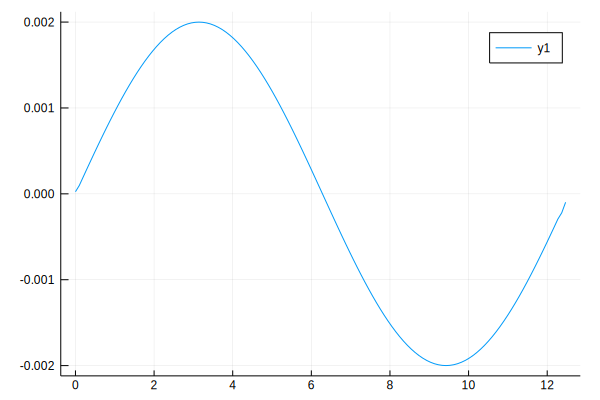

In [13]:
nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
x, e = landau(tf, nt)
plot( x, e)

In [9]:
using Profile

nt = 1000
tf = 100.0
t  = range(0.0, stop=tf, length=nt)
@time nrj = landau(tf, nt)
plot( t, nrj; label = "E")
plot!(t, -0.1533*t.-5.50; label="-0.1533t.-5.5")

MethodError: MethodError: no method matching adjoint(::Type{Poisson})
Closest candidates are:
  adjoint(!Matched::Missing) at missing.jl:79
  adjoint(!Matched::Number) at number.jl:193
  adjoint(!Matched::Adjoint{#s177,#s176} where #s176<:Union{StaticArray{Tuple{N},T,1} where T where N, StaticArray{Tuple{N,M},T,2} where T where M where N} where #s177) at /Users/navaro/.julia/packages/StaticArrays/WmJnA/src/linalg.jl:78
  ...

In [ ]:
using ProfileView
ProfileView.v